# Does MGC uncover the same subjects?

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

import sys

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
groups, labels, subjs = get_latents(base_dir, flag="_gcca", ids=True)

<IPython.core.display.Javascript object>

In [3]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "Expert",
    "n": "Novice",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
y_labels = [f"{label_transform[a]}" for a, b in y]

<IPython.core.display.Javascript object>

In [153]:
ways = [[0], [0], [0], [1], [1], [1]]
X, Y = k_sample_transform(groups, ways=ways)
X = X[:, :,].reshape(X.shape[0], -1)

<IPython.core.display.Javascript object>

In [154]:
X_dists = pairwise_distances(X, metric="euclidean")
Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

<IPython.core.display.Javascript object>

In [155]:
stat, pvalue, mgc_dict = multiscale_graphcorr(
    X_dists, Y_dists, workers=-1, reps=1, compute_distance=None, compute_c_mat=True
)
print(f'opt_scale: {mgc_dict["opt_scale"]}')

opt_scale: [3, 2]


<IPython.core.display.Javascript object>

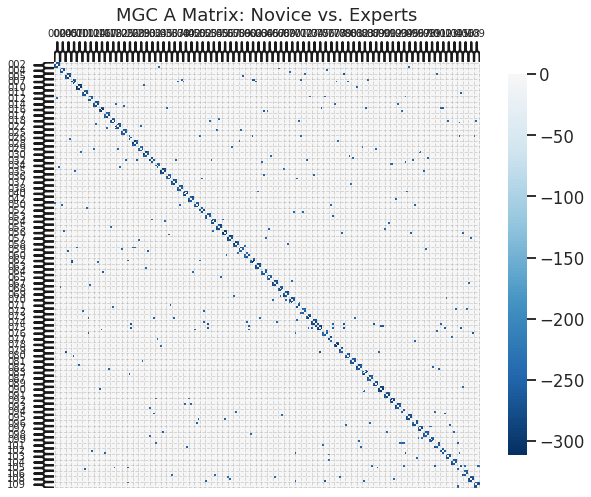

<IPython.core.display.Javascript object>

In [168]:
fig = heatmap(
    mgc_dict["a_mat"],
    title=f"MGC A Matrix: Novice vs. Experts",
    transform=None,
    inner_hier_labels=np.concatenate(subjs),
    hier_label_fontsize=10,
)
plt.show()

In [36]:
subj_adj = pairwise_distances(np.asarray(subjs)[:, None], metric=lambda x, y: x == y)

<IPython.core.display.Javascript object>

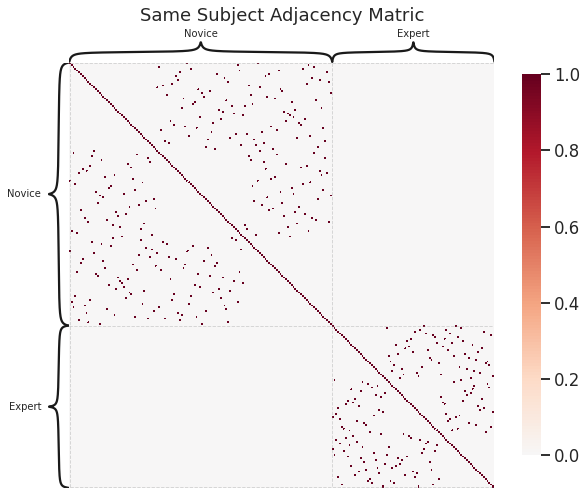

<IPython.core.display.Javascript object>

In [38]:
fig = heatmap(
    subj_adj,
    title=f"Same Subject Adjacency Matric",
    transform=None,
    inner_hier_labels=y_labels,
    hier_label_fontsize=10,
)
plt.show()

In [39]:
np.fill_diagonal(subj_adj, 0)

<IPython.core.display.Javascript object>

In [41]:
np.sum(((mgc_dict["a_mat"] != 0) - 2 * subj_adj) == -1) / np.sum(subj_adj)

0.9144736842105263

<IPython.core.display.Javascript object>

In [42]:
from sklearn.manifold import MDS

<IPython.core.display.Javascript object>

In [50]:
a_mat = (mgc_dict["a_mat"] + mgc_dict["a_mat"].T).copy() / 2

<IPython.core.display.Javascript object>

In [51]:
a_mat[a_mat == 0] = 1e6
np.fill_diagonal(a_mat, 0)

<IPython.core.display.Javascript object>

In [52]:
n_components = 3
a_mat_mds = MDS(n_components=n_components, dissimilarity="precomputed").fit_transform(
    a_mat
)

<IPython.core.display.Javascript object>

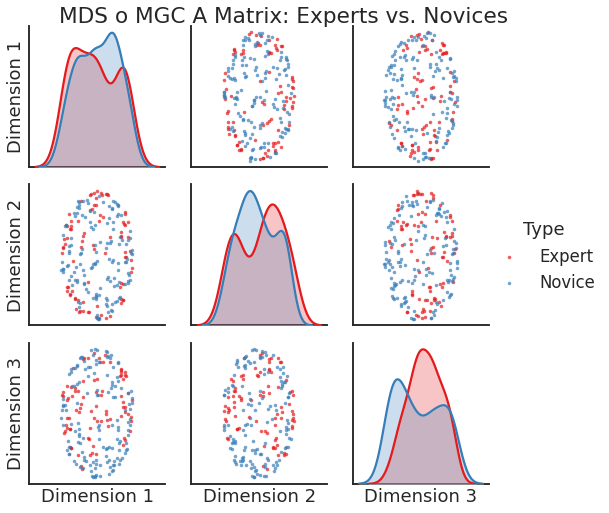

<IPython.core.display.Javascript object>

In [53]:
fig = pairplot(
    a_mat_mds, labels=y_labels, title=f"MDS o MGC A Matrix: Experts vs. Novices",
)
plt.show()

In [54]:
from sklearn.cluster import KMeans

<IPython.core.display.Javascript object>

In [59]:
kmeans = KMeans(n_clusters=int(228 / 3), random_state=0)
km_labels = kmeans.fit_predict(a_mat_mds)

<IPython.core.display.Javascript object>

In [62]:
km_adj = pairwise_distances(km_labels[:, None], metric=lambda x, y: x == y)

<IPython.core.display.Javascript object>

In [63]:
np.fill_diagonal(km_adj, 0)

<IPython.core.display.Javascript object>

In [65]:
np.sum((km_adj - 2 * subj_adj) == -1) / np.sum(km_adj)

0.6

<IPython.core.display.Javascript object>

## MGC on grouped by subject data

In [57]:
from collections import defaultdict

<IPython.core.display.Javascript object>

In [75]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
groups, labels, subjs = get_latents(base_dir, flag="_gcca", ids=True)

<IPython.core.display.Javascript object>

In [95]:
X.shape

(228, 18715)

<IPython.core.display.Javascript object>

In [127]:
g1_labels = [1, 2]
g2_labels = [4, 5]

<IPython.core.display.Javascript object>

In [128]:
X, Y = k_sample_transform(
    [np.vstack([np.asarray(groups[i]) for i in g1_labels])]
    + [np.vstack([np.asarray(groups[i]) for i in g2_labels])]
)

<IPython.core.display.Javascript object>

In [129]:
subj_list = np.concatenate(
    [np.asarray(subjs[i]) for i in g1_labels]
    + [np.asarray(subjs[i]) for i in g2_labels],
)

<IPython.core.display.Javascript object>

In [130]:
label_dict = {key: val for key, val in zip(subj_list, Y)}
d = defaultdict(list)
for key, val in zip(subj_list, X):
    d[key].append(val)

X_grouped = np.asarray([np.stack(val) for val in d.values()])
Y_grouped = np.asarray([label_dict[key] for key in d.keys()])

<IPython.core.display.Javascript object>

In [131]:
y_labels = ["Expert" if i[0] == 1 else "Novice" for i in Y_grouped]

<IPython.core.display.Javascript object>

In [134]:
pairwise_distances(Y_grouped, metric="sqeuclidean")

array([[0. , 0. , 0. , ..., 0.5, 0.5, 0.5],
       [0. , 0. , 0. , ..., 0.5, 0.5, 0.5],
       [0. , 0. , 0. , ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, ..., 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, ..., 0. , 0. , 0. ]])

<IPython.core.display.Javascript object>

In [110]:
c = X_grouped.shape[1]
X_dists = pairwise_distances(
    X_grouped.reshape(X_grouped.shape[0], -1),
    metric=lambda x, y: pairwise_distances(
        x.reshape(c, -1), y.reshape(c, -1), metric="euclidean"
    ).mean(),
)
Y_dists = pairwise_distances(Y_grouped, metric="sqeuclidean") / 2

<IPython.core.display.Javascript object>

In [116]:
len(Y)

228

<IPython.core.display.Javascript object>

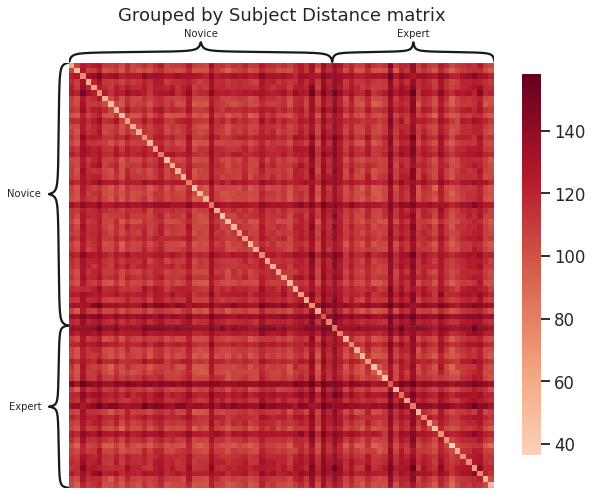

<IPython.core.display.Javascript object>

In [86]:
fig = heatmap(
    X_dists,
    title=f"Grouped by Subject Distance matrix",
    transform=None,
    inner_hier_labels=["Expert" if i[0] == 1 else "Novice" for i in Y_grouped],
    hier_label_fontsize=10,
)
plt.show()

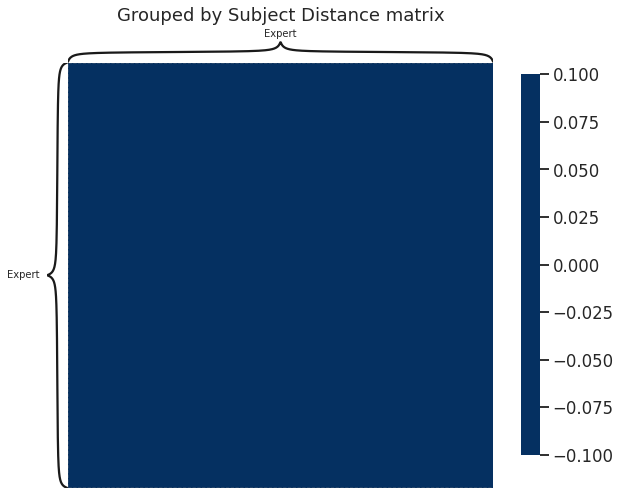

<IPython.core.display.Javascript object>

In [113]:
fig = heatmap(
    Y_dists,
    title=f"Grouped by Subject Distance matrix",
    transform=None,
    inner_hier_labels=y_labels,
    hier_label_fontsize=10,
)
plt.show()

In [88]:
stat, pvalue, mgc_dict = multiscale_graphcorr(
    X_dists, Y_dists, workers=-1, reps=1000, compute_distance=None, compute_c_mat=True
)
print(f'opt_scale: {mgc_dict["opt_scale"]}')

opt_scale: [76, 2]


<IPython.core.display.Javascript object>

In [89]:
pvalue

0.331

<IPython.core.display.Javascript object>

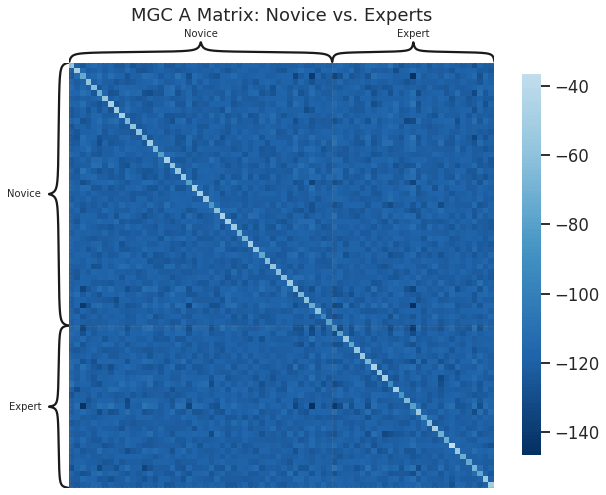

<IPython.core.display.Javascript object>

In [90]:
fig = heatmap(
    mgc_dict["a_mat"],
    title=f"MGC A Matrix: Novice vs. Experts",
    transform=None,
    inner_hier_labels=y_labels,
    hier_label_fontsize=10,
)
plt.show()

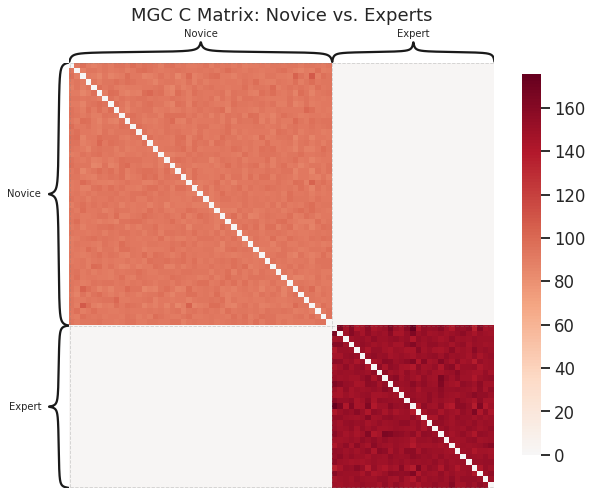

<IPython.core.display.Javascript object>

In [91]:
fig = heatmap(
    mgc_dict["c_mat"],
    title=f"MGC C Matrix: Novice vs. Experts",
    transform=None,
    inner_hier_labels=y_labels,
    hier_label_fontsize=10,
)
plt.show()

In [127]:
grads = [0]
g1_labels = [1, 2]
g2_labels = [3]

<IPython.core.display.Javascript object>

In [128]:
subj_list = np.concatenate(
    [np.asarray(subjs[i]) for i in g1_labels]
    + [np.asarray(subjs[i]) for i in g2_labels],
)

X, Y = k_sample_transform(
    [np.vstack([np.asarray(groups[i]) for i in g1_labels])]
    + [np.vstack([np.asarray(groups[i]) for i in g2_labels])]
)

X = X[:, :, grads].reshape(X.shape[0], -1)

label_dict = {key: val for key, val in zip(subj_list, Y)}
d = defaultdict(list)
for key, val in zip(subj_list, X):
    d[key].append(val)

X_grouped = [np.stack(val) for val in d.values()]
Y_grouped = np.asarray([label_dict[key] for key in d.keys()])


X_dists = np.asarray(
    [
        [
            np.sum(
                np.linalg.norm(i - j)
                for i in x.reshape(-1, 18715)
                for j in y.reshape(-1, 18715)
            )
            for x in X_grouped
        ]
        for y in X_grouped
    ]
)
Y_dists = pairwise_distances(Y_grouped, metric="sqeuclidean")

stat, pvalue, mgc_dict = multiscale_graphcorr(
    X_dists, Y_dists, workers=-1, reps=1, compute_distance=None, compute_c_mat=True
)
print(f'opt_scale: {mgc_dict["opt_scale"]}')

/home/rflperry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


opt_scale: [76, 2]


<IPython.core.display.Javascript object>

In [137]:
def doubly_center(a, fill_diag=False):
    n = a.shape[0]
    ac = np.repeat(((a.T.mean(axis=0) * n) / (n - 1)), n).reshape(-1, n).T
    ar = np.repeat(((a.mean(axis=0) * n) / (n - 1)), n).reshape(-1, n).T
    a = a - ar - ac
    if fill_diag:
        np.fill_diag(a, 0)
    return a

<IPython.core.display.Javascript object>

In [138]:
doubly_center(pairwise_distances(X)).sum()

-1320368.673300483

<IPython.core.display.Javascript object>

In [139]:
doubly_center(X_dists).sum()

-1330001.5516717313

<IPython.core.display.Javascript object>

In [145]:
temp = np.random.normal(0, 1, (6, 4))

<IPython.core.display.Javascript object>

In [148]:
doubly_center(pairwise_distances(temp)).sum()

-106.55903627597651

<IPython.core.display.Javascript object>

In [146]:
subjs = [0, 0, 0, 1, 1, 2]

<IPython.core.display.Javascript object>

In [147]:
d = defaultdict(list)
for key, val in zip(subjs, temp):
    d[key].append(val)

<IPython.core.display.Javascript object>

## Post scipy-modification

In [4]:
grads = [0]
g1_labels = [1, 2]
g2_labels = [3]

subj_list = np.concatenate(
    [np.asarray(subjs[i]) for i in g1_labels]
    + [np.asarray(subjs[i]) for i in g2_labels],
)

X, Y = k_sample_transform(
    [np.vstack([np.asarray(groups[i]) for i in g1_labels])]
    + [np.vstack([np.asarray(groups[i]) for i in g2_labels])]
)

X = X[:, :, grads].reshape(X.shape[0], -1)

X_dists = pairwise_distances(X, metric="euclidean")
Y_dists = pairwise_distances(Y, metric="sqeuclidean")

<IPython.core.display.Javascript object>

In [5]:
y_group_mat = pairwise_distances(subj_list[:, None], metric=lambda x, y: x != y)

<IPython.core.display.Javascript object>

In [6]:
stat, pvalue, mgc_dict = multiscale_graphcorr(
    X_dists,
    Y_dists,
    workers=-1,
    reps=1,
    compute_distance=None,
    compute_c_mat=True,
    y_groups=y_group_mat,
)
print(f'opt_scale: {mgc_dict["opt_scale"]}')

opt_scale: [105, 2]


<IPython.core.display.Javascript object>

In [14]:
pvalue

1.0

<IPython.core.display.Javascript object>

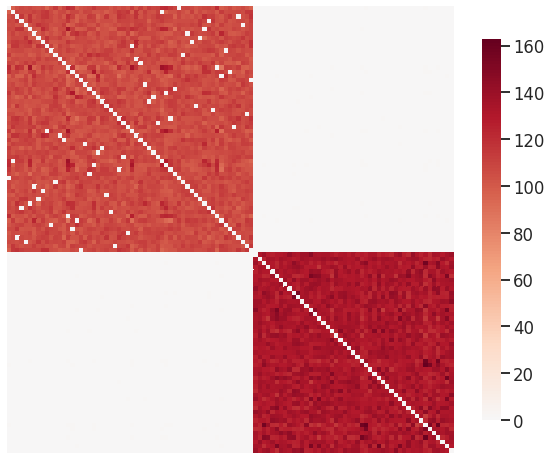

<IPython.core.display.Javascript object>

In [7]:
heatmap(mgc_dict["c_mat"])

In [9]:
y_group_mat

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

<IPython.core.display.Javascript object>

In [13]:
np.divide(np.sum([[0, 1], [0, 1]], axis=0), [1, 2])

array([0., 1.])

<IPython.core.display.Javascript object>

In [18]:
np.sum(y_group_mat, axis=0)

array([103., 103., 103., 103., 103., 103., 103., 103., 103., 103., 103.,
       103., 103., 103., 103., 103., 103., 103., 103., 103., 103., 103.,
       103., 103., 103., 103., 103., 103., 103., 103., 103., 103., 103.,
       103., 103., 103., 103., 103., 103., 103., 103., 103., 103., 103.,
       103., 103., 103., 103., 103., 103., 103., 103., 103., 103., 103.,
       103., 103., 103., 104., 104., 104., 104., 104., 104., 104., 104.,
       104., 104., 104., 104., 104., 104., 104., 104., 104., 104., 104.,
       104., 104., 104., 104., 104., 104., 104., 104., 104., 104., 104.,
       104., 104., 104., 104., 104., 104., 104., 104., 104., 104., 104.,
       104., 104., 104., 104., 104., 104.])

<IPython.core.display.Javascript object>

In [8]:
n = X_dists.shape[0]

<IPython.core.display.Javascript object>

In [14]:
np.repeat(np.divide(X_dists.mean(axis=0) * n, np.sum(y_group_mat, axis=0)), n).reshape(
    -1, n
).T

array([[124.04886541, 115.74191017, 127.94676478, ..., 108.09962514,
        134.88074263, 111.33480958],
       [124.04886541, 115.74191017, 127.94676478, ..., 108.09962514,
        134.88074263, 111.33480958],
       [124.04886541, 115.74191017, 127.94676478, ..., 108.09962514,
        134.88074263, 111.33480958],
       ...,
       [124.04886541, 115.74191017, 127.94676478, ..., 108.09962514,
        134.88074263, 111.33480958],
       [124.04886541, 115.74191017, 127.94676478, ..., 108.09962514,
        134.88074263, 111.33480958],
       [124.04886541, 115.74191017, 127.94676478, ..., 108.09962514,
        134.88074263, 111.33480958]])

<IPython.core.display.Javascript object>

In [10]:
X_dists.shape

(105, 105)

<IPython.core.display.Javascript object>

In [11]:
n

105

<IPython.core.display.Javascript object>

In [22]:
np.ones((10, 10))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

<IPython.core.display.Javascript object>